In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import keplergl as kpgl
import geopandas
from shapely.ops import unary_union
import datetime as dt
import json
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
#copied from briancpark for the following 2 cells that download and update
#John's Hopkins and NYT data...

#Run these lines on initial download of databases
#!git clone https://github.com/CSSEGISandData/COVID-19 databases/jhucsse
#!git clone https://github.com/nytimes/covid-19-data databases/nytimes

In [3]:
#Run this cell to update databases
!git -C databases/jhucsse pull origin master
#!ls databases/jhucsse

!git -C databases/nytimes pull origin master
#!ls databases/nytimes

Already up-to-date.


From https://github.com/CSSEGISandData/COVID-19
 * branch                master     -> FETCH_HEAD


Already up-to-date.

From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD


In [59]:
globalPops = pd.read_csv("databases/jhucsse/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

pops = globalPops[["Province_State", "Country_Region", "Population"]]
pops.columns = ["Province/State", "Country/Region", "Population"]

pops = pd.concat([pops, pd.DataFrame([["All", "World", 7800000000]], columns=pops.columns)]).reset_index().drop("index", axis=1)
pops

,Province/State,Country/Region,Population
0,NaN,Afghanistan,3.892834e+07
1,NaN,Albania,2.877800e+06
2,NaN,Algeria,4.385104e+07
3,NaN,Andorra,7.726500e+04
4,NaN,Angola,3.286627e+07
...,...,...,...
4167,Wyoming,US,2.346400e+04
4168,Wyoming,US,2.022600e+04
4169,Wyoming,US,7.805000e+03
4170,Wyoming,US,6.927000e+03


In [101]:
globalCases = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

worldCases = pd.DataFrame(data=[["All", "World", 80, 0] + list(globalCases[globalCases.columns[4:]].sum())], columns=globalCases.columns)

globalCases = globalCases.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Cases'})
worldCases = worldCases.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Cases'})

globalCases["Daily Cases"] = pd.to_numeric(globalCases["Total Cases"] - globalCases["Total Cases"].shift(1))
worldCases["Daily Cases"] = pd.to_numeric(worldCases["Total Cases"] - worldCases["Total Cases"].shift(1))

globalCases["Daily Cases"] = globalCases["Daily Cases"].clip(lower=0).fillna(0)
worldCases["Daily Cases"] = worldCases["Daily Cases"].clip(lower=0).fillna(0)

globalCases = globalCases.merge(pops, how='inner')
globalCases = globalCases[globalCases["Population"] > 1]
worldCases = worldCases.merge(pops, how='inner')
worldCases = worldCases[worldCases["Population"] > 1]

globalCases["Date"] = globalCases["Date"].astype(str) + ' 0:00'
globalCases["Date"] = pd.to_datetime(globalCases["Date"])

worldCases["Date"] = worldCases["Date"].astype(str) + ' 0:00'
worldCases["Date"] = pd.to_datetime(worldCases["Date"])

globalCases["Total/100k"] = (globalCases["Total Cases"] / globalCases["Population"]) * 100000
globalCases["Daily/100k"] = (globalCases["Daily Cases"] / globalCases["Population"]) * 100000

worldCases["Total/100k"] = (worldCases["Total Cases"] / worldCases["Population"]) * 100000
worldCases["Daily/100k"] = (worldCases["Daily Cases"] / worldCases["Population"]) * 100000

globalCases["World Case Counter"] = None

upperbound = worldCases.copy()
upperbound[upperbound.columns[5]]=globalCases[globalCases.columns[5]].max()
upperbound[upperbound.columns[6]]=0#globalCases[globalCases.columns[6]].max()
upperbound[upperbound.columns[8]]=globalCases[globalCases.columns[8]].max()
upperbound[upperbound.columns[9]]=0#globalCases[globalCases.columns[9]].max()
upperbound[upperbound.columns[0]]="Upper Bound"
upperbound["World Case Counter"] = worldCases["Total Cases"].copy()

globalCases = pd.concat([globalCases, upperbound]).reset_index().drop("index", axis=1)

globalCases

,Province/State,Country/Region,Lat,Long,Date,Total Cases,Daily Cases,Population,Total/100k,Daily/100k,World Case Counter
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0.0,3.892834e+07,0.000000,0.0,None
1,NaN,Afghanistan,33.93911,67.709953,2020-01-23,0,0.0,3.892834e+07,0.000000,0.0,None
2,NaN,Afghanistan,33.93911,67.709953,2020-01-24,0,0.0,3.892834e+07,0.000000,0.0,None
3,NaN,Afghanistan,33.93911,67.709953,2020-01-25,0,0.0,3.892834e+07,0.000000,0.0,None
4,NaN,Afghanistan,33.93911,67.709953,2020-01-26,0,0.0,3.892834e+07,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...
86236,Upper Bound,World,80.00000,0.000000,2020-12-05,15386562,0.0,7.800000e+09,9269.397528,0.0,66540007
86237,Upper Bound,World,80.00000,0.000000,2020-12-06,15386562,0.0,7.800000e+09,9269.397528,0.0,67073702
86238,Upper Bound,World,80.00000,0.000000,2020-12-07,15386562,0.0,7.800000e+09,9269.397528,0.0,67591311
86239,Upper Bound,World,80.00000,0.000000,2020-12-08,15386562,0.0,7.800000e+09,9269.397528,0.0,68225723


In [99]:
globalDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

worldDeaths = pd.DataFrame(data=[["All", "World", 80, 0] + list(globalDeaths[globalDeaths.columns[4:]].sum())], columns=globalDeaths.columns)

globalDeaths = globalDeaths.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Deaths'})
worldDeaths = worldDeaths.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Deaths'})

globalDeaths["Daily Deaths"] = pd.to_numeric(globalDeaths["Total Deaths"] - globalDeaths["Total Deaths"].shift(1))
worldDeaths["Daily Deaths"] = pd.to_numeric(worldDeaths["Total Deaths"] - worldDeaths["Total Deaths"].shift(1))

globalDeaths["Daily Deaths"] = globalDeaths["Daily Deaths"].clip(lower=0).fillna(0)
worldDeaths["Daily Deaths"] = worldDeaths["Daily Deaths"].clip(lower=0).fillna(0)

globalDeaths = globalDeaths.merge(pops, how='inner')
globalDeaths = globalDeaths[globalDeaths["Population"] > 1]
worldDeaths = worldDeaths.merge(pops, how='inner')
worldDeaths = worldDeaths[worldDeaths["Population"] > 1]

globalDeaths["Date"] = globalDeaths["Date"].astype(str) + ' 0:00'
globalDeaths["Date"] = pd.to_datetime(globalDeaths["Date"])

worldDeaths["Date"] = worldDeaths["Date"].astype(str) + ' 0:00'
worldDeaths["Date"] = pd.to_datetime(worldDeaths["Date"])

globalDeaths["Total/100k"] = (globalDeaths["Total Deaths"] / globalDeaths["Population"]) * 100000
globalDeaths["Daily/100k"] = (globalDeaths["Daily Deaths"] / globalDeaths["Population"]) * 100000

worldDeaths["Total/100k"] = (worldDeaths["Total Deaths"] / worldDeaths["Population"]) * 100000
worldDeaths["Daily/100k"] = (worldDeaths["Daily Deaths"] / worldDeaths["Population"]) * 100000

globalDeaths["World Death Counter"] = None

upperbound = worldDeaths.copy()
upperbound[upperbound.columns[5]]=globalDeaths[globalDeaths.columns[5]].max()
upperbound[upperbound.columns[6]]=0#globalDeaths[globalDeaths.columns[6]].max()
upperbound[upperbound.columns[8]]=globalDeaths[globalDeaths.columns[8]].max()
upperbound[upperbound.columns[9]]=0#globalDeaths[globalDeaths.columns[9]].max()
upperbound[upperbound.columns[0]]="Upper Bound"
upperbound["World Death Counter"] = worldDeaths["Total Deaths"].copy()

globalDeaths = pd.concat([globalDeaths, upperbound]).reset_index().drop("index", axis=1)

globalDeaths

,Province/State,Country/Region,Lat,Long,Date,Total Deaths,Daily Deaths,Population,Total/100k,Daily/100k,World Death Counter
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0.0,3.892834e+07,0.000000,0.0,None
1,NaN,Afghanistan,33.93911,67.709953,2020-01-23,0,0.0,3.892834e+07,0.000000,0.0,None
2,NaN,Afghanistan,33.93911,67.709953,2020-01-24,0,0.0,3.892834e+07,0.000000,0.0,None
3,NaN,Afghanistan,33.93911,67.709953,2020-01-25,0,0.0,3.892834e+07,0.000000,0.0,None
4,NaN,Afghanistan,33.93911,67.709953,2020-01-26,0,0.0,3.892834e+07,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...
86236,Upper Bound,World,80.00000,0.000000,2020-12-05,289373,0.0,7.800000e+09,151.885964,0.0,1528867
86237,Upper Bound,World,80.00000,0.000000,2020-12-06,289373,0.0,7.800000e+09,151.885964,0.0,1536055
86238,Upper Bound,World,80.00000,0.000000,2020-12-07,289373,0.0,7.800000e+09,151.885964,0.0,1544532
86239,Upper Bound,World,80.00000,0.000000,2020-12-08,289373,0.0,7.800000e+09,151.885964,0.0,1556834


In [126]:
usCases = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
usDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

usCases = usCases.drop(["UID", "iso2", "iso3", "code3"], axis=1)
usCases = usCases.set_index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', "Combined_Key"]).stack().reset_index().rename(columns = {'level_7' : 'Date', 0: 'Total Cases'})
usCases["Daily Cases"] = pd.to_numeric(usCases["Total Cases"] - usCases["Total Cases"].shift(1))
usCases["Population"] = usCases["Combined_Key"].map(usDeaths.set_index("Combined_Key")["Population"])
usCases = usCases.drop("Combined_Key", axis=1)

usCases["Daily Cases"] = usCases["Daily Cases"].clip(lower=0).fillna(0)

usCases["Date"] = usCases["Date"].astype(str) + ' 0:00'
usCases["Date"] = pd.to_datetime(usCases["Date"])

usCases

,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Date,Total Cases,Daily Cases,Population
0,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-22,0,0.0,55869
1,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-23,0,0.0,55869
2,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-24,0,0.0,55869
3,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-25,0,0.0,55869
4,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-26,0,0.0,55869
...,...,...,...,...,...,...,...,...,...,...
1078815,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-05,419,0.0,6927
1078816,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-06,420,1.0,6927
1078817,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-07,422,2.0,6927
1078818,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-08,425,3.0,6927


In [133]:
def squash_df(state_date_df):
    
    state_pop = state_date_df["Population"].sum()
    state_lat = state_date_df["Lat"].median()
    state_long = state_date_df["Long_"].median()
    state_tot_cases = state_date_df["Total Cases"].sum()
    state_date_cases = state_date_df["Daily Cases"].sum()
    
    row = [state_date_df["Province_State"].iloc[0], state_lat, state_long, state_date_df["Date"].iloc[0], state_tot_cases, state_date_cases, state_pop]
    cols = ["State", "Lat", "Long", "Date", "Total Cases", "Daily Cases", "Population"]
    
    row.append((state_tot_cases/state_pop)*100000)
    row.append((state_date_cases/state_pop)*100000)
    cols.append("Total/100k")
    cols.append("Daily/100k")
    
    return pd.DataFrame(data=[row], columns=cols)

grouped = usCases.groupby(["Province_State", "Date"])

state_df = pd.DataFrame(columns=["State", "Lat", "Long", "Date", "Total Cases", "Daily Cases", "Population", "Total/100k", "Daily/100k"])

for group in grouped.groups:
    if group[0] != "Diamond Princess" and group[0] != "Grand Princess":
        state_row = squash_df(grouped.get_group(group))
        state_df = pd.concat([state_df, state_row])

In [134]:
usTotalCases = globalCases[globalCases["Country/Region"]=="US"].drop(["Country/Region"], axis=1)
usTotalCases.rename(columns={"Province/State": "State", "World Case Counter": "US Case Counter"}, inplace=True)
usTotalCases["US Case Counter"] = usTotalCases["Total Cases"].copy()
usTotalCases["Total Cases"] = state_df["Total Cases"].max()
usTotalCases["Total/100k"] = state_df["Total/100k"].max()
usTotalCases["Daily Cases"] = 0
usTotalCases["Daily/100k"] = 0
usTotalCases["Long"] = -60

state_df["US Case Counter"] = None

state_df = pd.concat([state_df, usTotalCases])

stateCasesDF = state_df.reset_index().drop("index", axis=1)
stateCasesDF

,State,Lat,Long,Date,Total Cases,Daily Cases,Population,Total/100k,Daily/100k,US Case Counter
0,Alabama,32.850441,-86.651584,2020-01-22,0,0.0,4903185,0.000000,0.0,None
1,Alabama,32.850441,-86.651584,2020-01-23,0,0.0,4903185,0.000000,0.0,None
2,Alabama,32.850441,-86.651584,2020-01-24,0,0.0,4903185,0.000000,0.0,None
3,Alabama,32.850441,-86.651584,2020-01-25,0,0.0,4903185,0.000000,0.0,None
4,Alabama,32.850441,-86.651584,2020-01-26,0,0.0,4903185,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...
18406,NaN,40.000000,-60.000000,2020-12-05,1448987,0.0,3.29466e+08,11304.723238,0.0,14581318
18407,NaN,40.000000,-60.000000,2020-12-06,1448987,0.0,3.29466e+08,11304.723238,0.0,14756982
18408,NaN,40.000000,-60.000000,2020-12-07,1448987,0.0,3.29466e+08,11304.723238,0.0,14949417
18409,NaN,40.000000,-60.000000,2020-12-08,1448987,0.0,3.29466e+08,11304.723238,0.0,15165295


In [61]:
usDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

usDeaths = usDeaths.drop(["UID", "iso2", "iso3", "code3", "Combined_Key"], axis = 1)
usDeaths = usDeaths.set_index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Population']).stack().reset_index().rename(columns = {'level_7' : 'Date', 0: 'Total Deaths'})
usDeaths["Daily Deaths"] = pd.to_numeric(usDeaths["Total Deaths"] - usDeaths["Total Deaths"].shift(1))
usDeaths = usDeaths[['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Date', 'Total Deaths', 'Daily Deaths', 'Population']]

usDeaths["Daily Deaths"] = usDeaths["Daily Deaths"].clip(lower=0).fillna(0)

usDeaths["Date"] = usDeaths["Date"].astype(str) + ' 0:00'
usDeaths["Date"] = pd.to_datetime(usDeaths["Date"])

usDeaths

,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Date,Total Deaths,Daily Deaths,Population
0,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-22,0,0.0,55869
1,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-23,0,0.0,55869
2,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-24,0,0.0,55869
3,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-25,0,0.0,55869
4,1001.0,Autauga,Alabama,US,32.539527,-86.644082,2020-01-26,0,0.0,55869
...,...,...,...,...,...,...,...,...,...,...
1078815,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-05,2,0.0,6927
1078816,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-06,2,0.0,6927
1078817,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-07,2,0.0,6927
1078818,56045.0,Weston,Wyoming,US,43.839612,-104.567488,2020-12-08,2,0.0,6927


In [117]:
def squash_df(state_date_df):
    
    state_pop = state_date_df["Population"].sum()
    state_lat = state_date_df["Lat"].median()
    state_long = state_date_df["Long_"].median()
    state_tot_deaths = state_date_df["Total Deaths"].sum()
    state_date_deaths = state_date_df["Daily Deaths"].sum()
    
    row = [state_date_df["Province_State"].iloc[0], state_lat, state_long, state_date_df["Date"].iloc[0], state_tot_deaths, state_date_deaths, state_pop]
    cols = ["State", "Lat", "Long", "Date", "Total Deaths", "Daily Deaths", "Population"]
    
    row.append((state_tot_deaths/state_pop)*100000)
    row.append((state_date_deaths/state_pop)*100000)
    cols.append("Total/100k")
    cols.append("Daily/100k")
    
    return pd.DataFrame(data=[row], columns=cols)

grouped = usDeaths.groupby(["Province_State", "Date"])

state_df = pd.DataFrame(columns=["State", "Lat", "Long", "Date", "Total Deaths", "Daily Deaths", "Population", "Total/100k", "Daily/100k"])

for group in grouped.groups:
    if group[0] != "Diamond Princess" and group[0] != "Grand Princess":
        state_row = squash_df(grouped.get_group(group))
        state_df = pd.concat([state_df, state_row])

In [118]:
usTotalDeaths = globalDeaths[globalDeaths["Country/Region"]=="US"].drop(["Country/Region"], axis=1)
usTotalDeaths.rename(columns={"Province/State": "State", "World Death Counter": "US Death Counter"}, inplace=True)
usTotalDeaths["US Death Counter"] = usTotalDeaths["Total Deaths"].copy()
usTotalDeaths["Total Deaths"] = state_df["Total Deaths"].max()
usTotalDeaths["Total/100k"] = state_df["Total/100k"].max()
usTotalDeaths["Daily Deaths"] = 0
usTotalDeaths["Daily/100k"] = 0
usTotalDeaths["Long"] = -60

state_df["US Death Counter"] = None

state_df = pd.concat([state_df, usTotalDeaths])

stateDeathDF = state_df.reset_index().drop("index", axis=1)
stateDeathDF

,State,Lat,Long,Date,Total Deaths,Daily Deaths,Population,Total/100k,Daily/100k,US Death Counter
0,Alabama,32.850441,-86.651584,2020-01-22,0,0.0,4903185,0.000000,0.0,None
1,Alabama,32.850441,-86.651584,2020-01-23,0,0.0,4903185,0.000000,0.0,None
2,Alabama,32.850441,-86.651584,2020-01-24,0,0.0,4903185,0.000000,0.0,None
3,Alabama,32.850441,-86.651584,2020-01-25,0,0.0,4903185,0.000000,0.0,None
4,Alabama,32.850441,-86.651584,2020-01-26,0,0.0,4903185,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...
18406,NaN,40.000000,-60.000000,2020-12-05,35183,0.0,3.29466e+08,197.496338,0.0,281186
18407,NaN,40.000000,-60.000000,2020-12-06,35183,0.0,3.29466e+08,197.496338,0.0,282299
18408,NaN,40.000000,-60.000000,2020-12-07,35183,0.0,3.29466e+08,197.496338,0.0,283703
18409,NaN,40.000000,-60.000000,2020-12-08,35183,0.0,3.29466e+08,197.496338,0.0,286249


In [194]:
globalCasesKeplerConfig = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "Country Cases"
          ],
          "id": "6ue2iy9qg",
          "name": [
            "Date"
          ],
          "type": "timeRange",
          "value": [
            1605721536000,
            1607108256000
          ],
          "enlarged": True,
          "plotType": "lineChart",
          "animationWindow": "free",
          "yAxis": {
            "name": "World Case Counter",
            "type": "integer"
          }
        }
      ],
      "layers": [
        {
          "id": "kzpyg2r",
          "type": "hexagon",
          "config": {
            "dataId": "Country Cases",
            "label": "new layer",
            "color": [
              255,
              153,
              31
            ],
            "columns": {
              "lat": "Lat",
              "lng": "Long"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.4,
              "worldUnitSize": 200,
              "resolution": 8,
              "colorRange": {
                "name": "ColorBrewer OrRd-6",
                "type": "sequential",
                "category": "ColorBrewer",
                "colors": [
                  "#fef0d9",
                  "#fdd49e",
                  "#fdbb84",
                  "#fc8d59",
                  "#e34a33",
                  "#b30000"
                ],
                "reversed": False
              },
              "coverage": 1,
              "sizeRange": [
                0,
                600
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 100,
              "colorAggregation": "average",
              "sizeAggregation": "maximum",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "Daily/100k",
              "type": "real"
            },
            "colorScale": "quantile",
            "sizeField": {
              "name": "Total/100k",
              "type": "real"
            },
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "Country Cases": [
              {
                "name": "Province/State",
                "format": None
              },
              {
                "name": "Country/Region",
                "format": None
              },
              {
                "name": "Lat",
                "format": None
              },
              {
                "name": "Long",
                "format": None
              },
              {
                "name": "Date",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "additive",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 25.232876712328768,
      "dragRotate": True,
      "latitude": 6.91888770579188,
      "longitude": -43.480806334390515,
      "pitch": 48.90979865771812,
      "zoom": 1.191914993324477,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}


In [263]:
keplerMapGlobalCases = kpgl.KeplerGl(height=800, data = {"Country Cases": globalCases})
keplerMapGlobalCases.config = globalCasesKeplerConfig

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [215]:
globalDeathsKeplerConfig = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "Country Deaths"
          ],
          "id": "uh769yh1f",
          "name": [
            "Date"
          ],
          "type": "timeRange",
          "value": [
            1598283077472,
            1598803562472
          ],
          "enlarged": True,
          "plotType": "lineChart",
          "animationWindow": "free",
          "yAxis": {
            "name": "World Death Counter",
            "type": "integer"
          }
        }
      ],
      "layers": [
        {
          "id": "fixnujk",
          "type": "hexagon",
          "config": {
            "dataId": "Country Deaths",
            "label": "Country Deaths",
            "color": [
              183,
              136,
              94
            ],
            "columns": {
              "lat": "Lat",
              "lng": "Long"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.4,
              "worldUnitSize": 200,
              "resolution": 8,
              "colorRange": {
                "name": "ColorBrewer OrRd-6",
                "type": "sequential",
                "category": "ColorBrewer",
                "colors": [
                  "#fef0d9",
                  "#fdd49e",
                  "#fdbb84",
                  "#fc8d59",
                  "#e34a33",
                  "#b30000"
                ]
              },
              "coverage": 1,
              "sizeRange": [
                0,
                600
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 100,
              "colorAggregation": "average",
              "sizeAggregation": "maximum",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "Daily/100k",
              "type": "integer"
            },
            "colorScale": "quantile",
            "sizeField": {
              "name": "Total/100k",
              "type": "integer"
            },
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "Country Deaths": [
              {
                "name": "Province/State",
                "format": None
              },
              {
                "name": "Country/Region",
                "format": None
              },
              {
                "name": "Lat",
                "format": None
              },
              {
                "name": "Long",
                "format": None
              },
              {
                "name": "Date",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": 24,
      "dragRotate": True,
      "latitude": -0.5261232168451733,
      "longitude": -20.382949265382976,
      "pitch": 50,
      "zoom": 1.8856476549936705,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [264]:
keplerMapGlobalDeaths = kpgl.KeplerGl(height=800, data = {"Country Deaths": globalDeaths})
keplerMapGlobalDeaths.config = globalDeathsKeplerConfig

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [139]:
usCasesKeplerConfig = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "Country Cases"
          ],
          "id": "hcc228t5d",
          "name": [
            "Date"
          ],
          "type": "timeRange",
          "value": [
            1580939766720,
            1581461872720
          ],
          "enlarged": True,
          "plotType": "lineChart",
          "animationWindow": "free",
          "yAxis": {
            "name": "US Case Counter",
            "type": "integer"
          }
        }
      ],
      "layers": [
        {
          "id": "riljpin",
          "type": "hexagon",
          "config": {
            "dataId": "Country Cases",
            "label": "new layer",
            "color": [
              119,
              110,
              87
            ],
            "columns": {
              "lat": "Lat",
              "lng": "Long"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "worldUnitSize": 50,
              "resolution": 8,
              "colorRange": {
                "name": "ColorBrewer OrRd-6",
                "type": "sequential",
                "category": "ColorBrewer",
                "colors": [
                  "#fef0d9",
                  "#fdd49e",
                  "#fdbb84",
                  "#fc8d59",
                  "#e34a33",
                  "#b30000"
                ]
              },
              "coverage": 1,
              "sizeRange": [
                0,
                600
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 100,
              "colorAggregation": "average",
              "sizeAggregation": "maximum",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "Daily/100k",
              "type": "integer"
            },
            "colorScale": "quantile",
            "sizeField": {
              "name": "Total/100k",
              "type": "integer"
            },
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "Country Cases": [
              {
                "name": "State",
                "format": None
              },
              {
                "name": "Lat",
                "format": None
              },
              {
                "name": "Long",
                "format": None
              },
              {
                "name": "Date",
                "format": None
              },
              {
                "name": "Total Cases",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": -34.86206896551724,
      "dragRotate": True,
      "latitude": 38.200344135203245,
      "longitude": -81.66461501951106,
      "pitch": 54.63377297914083,
      "zoom": 2.9713519139135256,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [147]:
keplerMapUSCases = kpgl.KeplerGl(height=800, data = {"US Cases": stateCasesDF})
keplerMapUSCases.config = usCasesKeplerConfig

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [121]:
usDeathsKeplerConfig = {
  "version": "v1",
  "config": {
    "visState": {
      "filters": [
        {
          "dataId": [
            "US Deaths"
          ],
          "id": "azj5ofm9n",
          "name": [
            "Date"
          ],
          "type": "timeRange",
          "value": [
            1580671296000,
            1581544083000
          ],
          "enlarged": True,
          "plotType": "lineChart",
          "animationWindow": "incremental",
          "yAxis": {
            "name": "US Death Counter",
            "type": "integer"
          }
        }
      ],
      "layers": [
        {
          "id": "vudyyh",
          "type": "hexagon",
          "config": {
            "dataId": "US Deaths",
            "label": "US Deaths",
            "color": [
              248,
              149,
              112
            ],
            "columns": {
              "lat": "Lat",
              "lng": "Long"
            },
            "isVisible": True,
            "visConfig": {
              "opacity": 0.8,
              "worldUnitSize": 50,
              "resolution": 8,
              "colorRange": {
                "name": "ColorBrewer OrRd-6",
                "type": "sequential",
                "category": "ColorBrewer",
                "colors": [
                  "#fef0d9",
                  "#fdd49e",
                  "#fdbb84",
                  "#fc8d59",
                  "#e34a33",
                  "#b30000"
                ]
              },
              "coverage": 1,
              "sizeRange": [
                0,
                600
              ],
              "percentile": [
                0,
                100
              ],
              "elevationPercentile": [
                0,
                100
              ],
              "elevationScale": 100,
              "colorAggregation": "average",
              "sizeAggregation": "maximum",
              "enable3d": True
            },
            "hidden": False,
            "textLabel": [
              {
                "field": None,
                "color": [
                  255,
                  255,
                  255
                ],
                "size": 18,
                "offset": [
                  0,
                  0
                ],
                "anchor": "start",
                "alignment": "center"
              }
            ]
          },
          "visualChannels": {
            "colorField": {
              "name": "Daily/100k",
              "type": "integer"
            },
            "colorScale": "quantile",
            "sizeField": {
              "name": "Total/100k",
              "type": "integer"
            },
            "sizeScale": "linear"
          }
        }
      ],
      "interactionConfig": {
        "tooltip": {
          "fieldsToShow": {
            "US Deaths": [
              {
                "name": "State",
                "format": None
              },
              {
                "name": "Lat",
                "format": None
              },
              {
                "name": "Long",
                "format": None
              },
              {
                "name": "Date",
                "format": None
              },
              {
                "name": "Total Deaths",
                "format": None
              }
            ]
          },
          "compareMode": False,
          "compareType": "absolute",
          "enabled": True
        },
        "brush": {
          "size": 0.5,
          "enabled": False
        },
        "geocoder": {
          "enabled": False
        },
        "coordinate": {
          "enabled": False
        }
      },
      "layerBlending": "normal",
      "splitMaps": [],
      "animationConfig": {
        "currentTime": None,
        "speed": 1
      }
    },
    "mapState": {
      "bearing": -46.44827586206896,
      "dragRotate": True,
      "latitude": 43.1434049956351,
      "longitude": -73.88210299953471,
      "pitch": 49.91754043366302,
      "zoom": 3.356394193626022,
      "isSplit": False
    },
    "mapStyle": {
      "styleType": "dark",
      "topLayerGroups": {},
      "visibleLayerGroups": {
        "label": True,
        "road": True,
        "border": False,
        "building": True,
        "water": True,
        "land": True,
        "3d building": False
      },
      "threeDBuildingColor": [
        9.665468314072013,
        17.18305478057247,
        31.1442867897876
      ],
      "mapStyles": {}
    }
  }
}

In [122]:
keplerMapUSDeaths = kpgl.KeplerGl(height=800, data = {"US Deaths": stateDeathDF})
keplerMapUSDeaths.config = usDeathsKeplerConfig

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [146]:
#usCombinedKeplerConfig

In [164]:
keplerMapUSCombined = kpgl.KeplerGl(height=800, data = {"US Combined": stateCombined})
#keplerMapUSCombined.config = usDeathsKeplerConfig

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


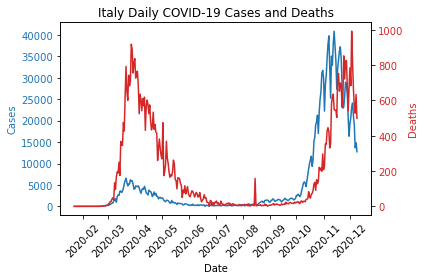

In [205]:
figure, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel("Date")
ax1.set_ylabel('Cases', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.plot(globalCases[globalCases["Country/Region"]=="Italy"]["Date"],globalCases[globalCases["Country/Region"]=="Italy"]["Daily Cases"],color=color, label="Confirmed Cases")

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Deaths', color=color)
ax2.plot(globalDeaths[globalDeaths["Country/Region"]=="Italy"]["Date"],globalDeaths[globalDeaths["Country/Region"]=="Italy"]["Daily Deaths"],color=color, label="Deaths")
ax2.tick_params(axis='y', labelcolor=color)

plt.sca(ax1)
plt.xticks(rotation=45)
plt.title("Italy Daily COVID-19 Cases and Deaths")
figure.tight_layout()
plt.show()

In [110]:
#keplerMapGlobalCases

In [109]:
#keplerMapGlobalDeaths

In [149]:
#keplerMapUSCases

In [135]:
#keplerMapUSDeaths

In [168]:
usDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

usDeaths = usDeaths.drop(["UID", "iso2", "iso3", "code3", "Combined_Key"], axis = 1)
usDeaths = usDeaths.set_index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Population']).stack().reset_index().rename(columns = {'level_7' : 'Date', 0: 'Total Deaths'})
usDeaths["Daily Deaths"] = pd.to_numeric(usDeaths["Total Deaths"] - usDeaths["Total Deaths"].shift(1))
usDeaths = usDeaths[['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Date', 'Total Deaths', 'Daily Deaths', 'Population']]

usDeaths["Daily Deaths"] = usDeaths["Daily Deaths"].clip(lower=0).fillna(0)

usDeaths["Date"] = usDeaths["Date"].astype(str) + ' 0:00'
usDeaths["Date"] = pd.to_datetime(usDeaths["Date"])

def squash_df(state_date_df):
    
    state_pop = state_date_df["Population"].sum()
    state_lat = state_date_df["Lat"].median()
    state_long = state_date_df["Long_"].median()
    state_tot_deaths = state_date_df["Total Deaths"].sum()
    state_date_deaths = state_date_df["Daily Deaths"].sum()
    
    row = [state_date_df["Province_State"].iloc[0], "US", state_lat, state_long, state_date_df["Date"].iloc[0], state_tot_deaths, state_date_deaths, state_pop]
    cols = ["Province/State", "Country/Region", "Lat", "Long", "Date", "Total Deaths", "Daily Deaths", "Population"]
    
    row.append((state_tot_deaths/state_pop)*100000)
    row.append((state_date_deaths/state_pop)*100000)
    cols.append("Total/100k")
    cols.append("Daily/100k")
    
    return pd.DataFrame(data=[row], columns=cols)

grouped = usDeaths.groupby(["Province_State", "Date"])

state_df = pd.DataFrame(columns=["Province/State", "Country/Region", "Lat", "Long", "Date", "Total Deaths", "Daily Deaths", "Population", "Total/100k", "Daily/100k"])

for group in grouped.groups:
    if group[0] != "Diamond Princess" and group[0] != "Grand Princess":
        state_row = squash_df(grouped.get_group(group))
        state_df = pd.concat([state_df, state_row])

In [173]:
state_df["World Death Counter"] = None
state_df = state_df.reset_index().drop("index",axis=1)
state_df

,Province/State,Country/Region,Lat,Long,Date,Total Deaths,Daily Deaths,Population,Total/100k,Daily/100k,World Death Counter
0,Alabama,US,32.850441,-86.651584,2020-01-22,0,0.0,4903185,0.000000,0.000000,None
1,Alabama,US,32.850441,-86.651584,2020-01-23,0,0.0,4903185,0.000000,0.000000,None
2,Alabama,US,32.850441,-86.651584,2020-01-24,0,0.0,4903185,0.000000,0.000000,None
3,Alabama,US,32.850441,-86.651584,2020-01-25,0,0.0,4903185,0.000000,0.000000,None
4,Alabama,US,32.850441,-86.651584,2020-01-26,0,0.0,4903185,0.000000,0.000000,None
...,...,...,...,...,...,...,...,...,...,...,...
18083,Wyoming,US,42.972723,-106.797885,2020-12-05,266,0.0,578759,45.960408,0.000000,None
18084,Wyoming,US,42.972723,-106.797885,2020-12-06,266,0.0,578759,45.960408,0.000000,None
18085,Wyoming,US,42.972723,-106.797885,2020-12-07,289,23.0,578759,49.934429,3.974020,None
18086,Wyoming,US,42.972723,-106.797885,2020-12-08,289,0.0,578759,49.934429,0.000000,None


In [184]:
globalDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

worldDeaths = pd.DataFrame(data=[["All", "World", 80, 0] + list(globalDeaths[globalDeaths.columns[4:]].sum())], columns=globalDeaths.columns)

globalDeaths = globalDeaths.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Deaths'})
worldDeaths = worldDeaths.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Deaths'})

globalDeaths["Daily Deaths"] = pd.to_numeric(globalDeaths["Total Deaths"] - globalDeaths["Total Deaths"].shift(1))
worldDeaths["Daily Deaths"] = pd.to_numeric(worldDeaths["Total Deaths"] - worldDeaths["Total Deaths"].shift(1))

globalDeaths["Daily Deaths"] = globalDeaths["Daily Deaths"].clip(lower=0).fillna(0)
worldDeaths["Daily Deaths"] = worldDeaths["Daily Deaths"].clip(lower=0).fillna(0)

globalDeaths = globalDeaths.merge(pops, how='inner')
globalDeaths = globalDeaths[globalDeaths["Population"] > 1]
worldDeaths = worldDeaths.merge(pops, how='inner')
worldDeaths = worldDeaths[worldDeaths["Population"] > 1]

globalDeaths["Date"] = globalDeaths["Date"].astype(str) + ' 0:00'
globalDeaths["Date"] = pd.to_datetime(globalDeaths["Date"])

worldDeaths["Date"] = worldDeaths["Date"].astype(str) + ' 0:00'
worldDeaths["Date"] = pd.to_datetime(worldDeaths["Date"])

globalDeaths["Total/100k"] = (globalDeaths["Total Deaths"] / globalDeaths["Population"]) * 100000
globalDeaths["Daily/100k"] = (globalDeaths["Daily Deaths"] / globalDeaths["Population"]) * 100000

worldDeaths["Total/100k"] = (worldDeaths["Total Deaths"] / worldDeaths["Population"]) * 100000
worldDeaths["Daily/100k"] = (worldDeaths["Daily Deaths"] / worldDeaths["Population"]) * 100000

globalDeaths = globalDeaths[globalDeaths["Country/Region"]!="US"].reset_index().drop("index",axis=1)
globalDeaths["World Death Counter"] = None

upperbound = worldDeaths.copy()
upperbound[upperbound.columns[5]]=max(globalDeaths[globalDeaths.columns[5]].max(), state_df[state_df.columns[5]].max())
upperbound[upperbound.columns[6]]=0#globalDeaths[globalDeaths.columns[6]].max()
upperbound[upperbound.columns[8]]=max(globalDeaths[globalDeaths.columns[8]].max(), state_df[state_df.columns[8]].max())
upperbound[upperbound.columns[9]]=0#globalDeaths[globalDeaths.columns[9]].max()
upperbound[upperbound.columns[0]]="Upper Bound"
upperbound["World Death Counter"] = worldDeaths["Total Deaths"].copy()

globalDeaths = pd.concat([globalDeaths, state_df, upperbound]).reset_index().drop("index", axis=1)

globalDeaths

,Province/State,Country/Region,Lat,Long,Date,Total Deaths,Daily Deaths,Population,Total/100k,Daily/100k,World Death Counter
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0.0,3.89283e+07,0.000000,0.0,None
1,NaN,Afghanistan,33.93911,67.709953,2020-01-23,0,0.0,3.89283e+07,0.000000,0.0,None
2,NaN,Afghanistan,33.93911,67.709953,2020-01-24,0,0.0,3.89283e+07,0.000000,0.0,None
3,NaN,Afghanistan,33.93911,67.709953,2020-01-25,0,0.0,3.89283e+07,0.000000,0.0,None
4,NaN,Afghanistan,33.93911,67.709953,2020-01-26,0,0.0,3.89283e+07,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...
104001,Upper Bound,World,80.00000,0.000000,2020-12-05,178995,0.0,7.8e+09,197.496338,0.0,1528867
104002,Upper Bound,World,80.00000,0.000000,2020-12-06,178995,0.0,7.8e+09,197.496338,0.0,1536055
104003,Upper Bound,World,80.00000,0.000000,2020-12-07,178995,0.0,7.8e+09,197.496338,0.0,1544532
104004,Upper Bound,World,80.00000,0.000000,2020-12-08,178995,0.0,7.8e+09,197.496338,0.0,1556834


In [ ]:
#globalDeathsKeplerConfig

In [207]:
keplerMapGlobalDeaths = kpgl.KeplerGl(height=800, data = {"Country Deaths": globalDeaths})
#keplerMapGlobalDeaths.config = globalDeathsKeplerConfig

#keplerMapGlobalDeaths

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [186]:
usCases = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
usDeaths = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

usCases = usCases.drop(["UID", "iso2", "iso3", "code3"], axis=1)
usCases = usCases.set_index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', "Combined_Key"]).stack().reset_index().rename(columns = {'level_7' : 'Date', 0: 'Total Cases'})
usCases["Daily Cases"] = pd.to_numeric(usCases["Total Cases"] - usCases["Total Cases"].shift(1))
usCases["Population"] = usCases["Combined_Key"].map(usDeaths.set_index("Combined_Key")["Population"])
usCases = usCases.drop("Combined_Key", axis=1)

usCases["Daily Cases"] = usCases["Daily Cases"].clip(lower=0).fillna(0)

usCases["Date"] = usCases["Date"].astype(str) + ' 0:00'
usCases["Date"] = pd.to_datetime(usCases["Date"])

def squash_df(state_date_df):
    
    state_pop = state_date_df["Population"].sum()
    state_lat = state_date_df["Lat"].median()
    state_long = state_date_df["Long_"].median()
    state_tot_cases = state_date_df["Total Cases"].sum()
    state_date_cases = state_date_df["Daily Cases"].sum()
    
    row = [state_date_df["Province_State"].iloc[0], "US", state_lat, state_long, state_date_df["Date"].iloc[0], state_tot_cases, state_date_cases, state_pop]
    cols = ["Province/State", "Country/Region", "Lat", "Long", "Date", "Total Cases", "Daily Cases", "Population"]
    
    row.append((state_tot_cases/state_pop)*100000)
    row.append((state_date_cases/state_pop)*100000)
    cols.append("Total/100k")
    cols.append("Daily/100k")
    
    return pd.DataFrame(data=[row], columns=cols)

grouped = usCases.groupby(["Province_State", "Date"])

state_df = pd.DataFrame(columns=["Province/State", "Country/Region", "Lat", "Long", "Date", "Total Cases", "Daily Cases", "Population", "Total/100k", "Daily/100k"])

for group in grouped.groups:
    if group[0] != "Diamond Princess" and group[0] != "Grand Princess":
        state_row = squash_df(grouped.get_group(group))
        state_df = pd.concat([state_df, state_row])

In [187]:
state_df["World Case Counter"] = None
state_df = state_df.reset_index().drop("index",axis=1)
state_df

,Province/State,Country/Region,Lat,Long,Date,Total Cases,Daily Cases,Population,Total/100k,Daily/100k,World Case Counter
0,Alabama,US,32.850441,-86.651584,2020-01-22,0,0.0,4903185,0.000000,0.000000,None
1,Alabama,US,32.850441,-86.651584,2020-01-23,0,0.0,4903185,0.000000,0.000000,None
2,Alabama,US,32.850441,-86.651584,2020-01-24,0,0.0,4903185,0.000000,0.000000,None
3,Alabama,US,32.850441,-86.651584,2020-01-25,0,0.0,4903185,0.000000,0.000000,None
4,Alabama,US,32.850441,-86.651584,2020-01-26,0,0.0,4903185,0.000000,0.000000,None
...,...,...,...,...,...,...,...,...,...,...,...
18083,Wyoming,US,42.972723,-106.797885,2020-12-05,35941,205.0,578759,6210.011421,35.420615,None
18084,Wyoming,US,42.972723,-106.797885,2020-12-06,36317,376.0,578759,6274.978013,64.966592,None
18085,Wyoming,US,42.972723,-106.797885,2020-12-07,36985,668.0,578759,6390.397385,115.419371,None
18086,Wyoming,US,42.972723,-106.797885,2020-12-08,37475,490.0,578759,6475.061295,84.663910,None


In [191]:
globalCases = pd.read_csv("databases/jhucsse/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

worldCases = pd.DataFrame(data=[["All", "World", 80, 0] + list(globalCases[globalCases.columns[4:]].sum())], columns=globalCases.columns)

globalCases = globalCases.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Cases'})
worldCases = worldCases.set_index(['Province/State', 'Country/Region', 'Lat', 'Long']).stack().reset_index().rename(columns = {'level_4' : 'Date', 0: 'Total Cases'})

globalCases["Daily Cases"] = pd.to_numeric(globalCases["Total Cases"] - globalCases["Total Cases"].shift(1))
worldCases["Daily Cases"] = pd.to_numeric(worldCases["Total Cases"] - worldCases["Total Cases"].shift(1))

globalCases["Daily Cases"] = globalCases["Daily Cases"].clip(lower=0).fillna(0)
worldCases["Daily Cases"] = worldCases["Daily Cases"].clip(lower=0).fillna(0)

globalCases = globalCases.merge(pops, how='inner')
globalCases = globalCases[globalCases["Population"] > 1]
worldCases = worldCases.merge(pops, how='inner')
worldCases = worldCases[worldCases["Population"] > 1]

globalCases["Date"] = globalCases["Date"].astype(str) + ' 0:00'
globalCases["Date"] = pd.to_datetime(globalCases["Date"])

worldCases["Date"] = worldCases["Date"].astype(str) + ' 0:00'
worldCases["Date"] = pd.to_datetime(worldCases["Date"])

globalCases["Total/100k"] = (globalCases["Total Cases"] / globalCases["Population"]) * 100000
globalCases["Daily/100k"] = (globalCases["Daily Cases"] / globalCases["Population"]) * 100000

worldCases["Total/100k"] = (worldCases["Total Cases"] / worldCases["Population"]) * 100000
worldCases["Daily/100k"] = (worldCases["Daily Cases"] / worldCases["Population"]) * 100000

globalCases = globalCases[globalCases["Country/Region"]!="US"].reset_index().drop("index",axis=1)
globalCases["World Case Counter"] = None

upperbound = worldCases.copy()
upperbound[upperbound.columns[5]]=max(globalCases[globalCases.columns[5]].max(), state_df[state_df.columns[5]].max())
upperbound[upperbound.columns[6]]=0#globalCases[globalCases.columns[6]].max()
upperbound[upperbound.columns[8]]=max(globalCases[globalCases.columns[8]].max(), state_df[state_df.columns[8]].max())
upperbound[upperbound.columns[9]]=0#globalCases[globalCases.columns[9]].max()
upperbound[upperbound.columns[0]]="Upper Bound"
upperbound["World Case Counter"] = worldCases["Total Cases"].copy()

globalCases = pd.concat([globalCases, state_df, upperbound]).reset_index().drop("index", axis=1)

globalCases

,Province/State,Country/Region,Lat,Long,Date,Total Cases,Daily Cases,Population,Total/100k,Daily/100k,World Case Counter
0,NaN,Afghanistan,33.93911,67.709953,2020-01-22,0,0.0,3.89283e+07,0.000000,0.0,None
1,NaN,Afghanistan,33.93911,67.709953,2020-01-23,0,0.0,3.89283e+07,0.000000,0.0,None
2,NaN,Afghanistan,33.93911,67.709953,2020-01-24,0,0.0,3.89283e+07,0.000000,0.0,None
3,NaN,Afghanistan,33.93911,67.709953,2020-01-25,0,0.0,3.89283e+07,0.000000,0.0,None
4,NaN,Afghanistan,33.93911,67.709953,2020-01-26,0,0.0,3.89283e+07,0.000000,0.0,None
...,...,...,...,...,...,...,...,...,...,...,...
104001,Upper Bound,World,80.00000,0.000000,2020-12-05,9767371,0.0,7.8e+09,11304.723238,0.0,66540007
104002,Upper Bound,World,80.00000,0.000000,2020-12-06,9767371,0.0,7.8e+09,11304.723238,0.0,67073702
104003,Upper Bound,World,80.00000,0.000000,2020-12-07,9767371,0.0,7.8e+09,11304.723238,0.0,67591311
104004,Upper Bound,World,80.00000,0.000000,2020-12-08,9767371,0.0,7.8e+09,11304.723238,0.0,68225723


In [206]:
#keplerMapGlobalCases = kpgl.KeplerGl(height=800, data = {"Country Cases": globalCases})
#keplerMapGlobalDeaths.config = globalDeathsKeplerConfig

#keplerMapGlobalCases